In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import xml.etree.ElementTree as ET
import cv2
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, accuracy_score

from mlxtend.plotting import plot_decision_regions
## pip install mlxtend
from sklearn.model_selection import cross_val_score
from sklearn import utils

import tensorflow as tf
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers


from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Activation, Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.model_selection import train_test_split



import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [2]:
# Merkmalsreduktion
# Schneide irrelevante Informationen aus dem Bilder heraus.
# Speichere die Merkalsreduzierten Bilder in einen neuen Ordner /data/

all_dogs = 0  # Zählvariable der Hundebilder 
data_dir = os.getcwd() + '\\'
breed_list = os.listdir(data_dir + 'images\\Images\\')
os.makedirs('data', exist_ok=True)


for breed in breed_list:
    os.makedirs('data\\' + breed, exist_ok=True)
for breed in os.listdir('data'):
    for file in os.listdir(data_dir + 'annotation\\Annotation\\' + breed):
        img = Image.open(data_dir + 'images\\Images\\' + breed + '\\' + file + '.jpg')
        tree = ET.parse(data_dir + 'annotation\\Annotation\\' + breed + '\\' + file)
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin,ymin,xmax,ymax))
        img = img.convert('RGB')
        img.save('data//' + breed + '/' + file + '.jpg')
        all_dogs = all_dogs+1

In [3]:
#lese daten  in "bilder aka imagepath array ein und der dazugehörigen daten aka label_array"
# Speichere die Bilddaten (RGB Werte) in ein array
# Speichere die Hunderassen in 
SCALE = 32 # Setzte Skalierungsfaktor auf welchen die Bilder alle Skaliert werden
data_array = []
label_array= []
breedNum = 0
for breed in breed_list:
    imagepath=(data_dir + 'data\\' + breed )
    for img in os.listdir(imagepath):
        img_array=cv2.imread(os.path.join(imagepath,img))
        #data_array.append(img_array.tolist())
        data_array.append(cv2.resize(img_array,(SCALE,SCALE)).tolist())
        label_array.append(breedNum) # Setze Hunderasseart auf eine ID
    breedNum = breedNum + 1

In [4]:
# Umbennenen der Hunderassen. (Scheide Ziffern weg) 
# Zu besseren Darstellung in den Legenden der folgenden Schaubilder
for i in range(0, len(breed_list)):
    ar = breed_list[i].split('-')
    breed_list[i] = ar[1]

In [5]:

label_array, data_array = utils.shuffle(label_array, data_array)
# Einteilen der TEST und TRAIN Daten
size_of_train= int(all_dogs*0.75)
size_of_test = int(all_dogs*0.25)
X_train = np.array(data_array[:size_of_train])
Y_train = np.array(label_array[:size_of_train])
X_test = np.array(data_array[-size_of_test:])
Y_test = np.array(label_array[-size_of_test:])


In [6]:
input_shape = (SCALE, SCALE, 3)


X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)
X_train=X_train / 255.0

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 3)
X_test=X_test / 255.0

Y_train_old = Y_train
Y_train = tf.one_hot(Y_train.astype(np.int32), depth=10)
Y_test = tf.one_hot(Y_test.astype(np.int32), depth=10)


In [7]:
batch_size = 32
num_classes = 10  ##(x * Hunderasse)
epochs = 10

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=X_train.shape[1:], activation='relu'),
    #tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),


    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.30),


    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.30),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax'),

    
 ])
model.compile(optimizer="adam",
            loss='categorical_crossentropy', metrics=['acc'])

#model.summary()


In [8]:
history =model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          #shuffle=True,
          #verbose=0
          )

Epoch 1/10
20/20 [==============================] - 1s 19ms/step - loss: 1.6199 - acc: 0.2754
Epoch 2/10
20/20 [==============================] - 0s 21ms/step - loss: 1.2177 - acc: 0.4538
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 0.9644 - acc: 0.5806
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 0.8537 - acc: 0.6338
Epoch 5/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6828 - acc: 0.7089
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6147 - acc: 0.7387
Epoch 7/10
20/20 [==============================] - 0s 19ms/step - loss: 0.5960 - acc: 0.7590
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5379 - acc: 0.7903
Epoch 9/10
20/20 [==============================] - 1s 31ms/step - loss: 0.5247 - acc: 0.7809
Epoch 10/10
20/20 [==============================] - 0s 19ms/step - loss: 0.4393 - acc: 0.8310


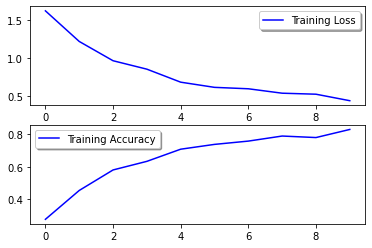

In [9]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
legend = ax[0].legend(loc='best', shadow=True)
ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [11]:

# Führe die Kreuzvalidierung durch
from sklearn.model_selection import KFold


# Definiere die Anzahl der Folds
num_folds = 3

# Erstelle ein int, um die Genauigkeit für jeden Fold zu speichern
acc =0

# Teile das Modell in Folds auf
folds = KFold(n_splits=num_folds, shuffle=True)

# Führe die Kreuzvalidierung durch
for train_index, test_index in folds.split(X_train):

    # Manulles 3-Fold Kreuzvalidieren
    # Schuffeln der Bild und Label Daten
    label_array, data_array = utils.shuffle(label_array, data_array)
    # Einteilen der TEST und TRAIN Daten
    size_of_train= int(all_dogs*0.75)
    size_of_test = int(all_dogs*0.25)
    X_train = np.array(data_array[:size_of_train])
    Y_train = np.array(label_array[:size_of_train])
    X_test = np.array(data_array[-size_of_test:])
    Y_test = np.array(label_array[-size_of_test:])
    
    # Daten in Shape bringen
    X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)
    X_train=X_train / 255.0
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 3)
    X_test=X_test / 255.0   
    Y_train = tf.one_hot(Y_train.astype(np.int32), depth=10)
    Y_test = tf.one_hot(Y_test.astype(np.int32), depth=10)



    model.fit(X_train, Y_train, epochs=3, verbose=0)
    accuracy = model.evaluate(X_test, Y_test)
    print(accuracy[1])
    acc = acc +accuracy[1]
# Berechne die Durchschnittsgenauigkeit
print("Durchschnittsgenauigkeit nach"+str(num_folds)+"-Fold-Validierung:", (acc / num_folds))


7/7 [==============================] - 0s 7ms/step - loss: 0.5698 - acc: 0.7840
0.7840375304222107
7/7 [==============================] - 0s 5ms/step - loss: 0.4640 - acc: 0.8498
0.8497652411460876
7/7 [==============================] - 0s 6ms/step - loss: 0.3534 - acc: 0.8732
0.8732394576072693
Durchschnittsgenauigkeit nach3-Fold-Validierung: 0.8356807430585226


 X-Achse = Predicted Labeles Y-Achse = die wahren Labels 


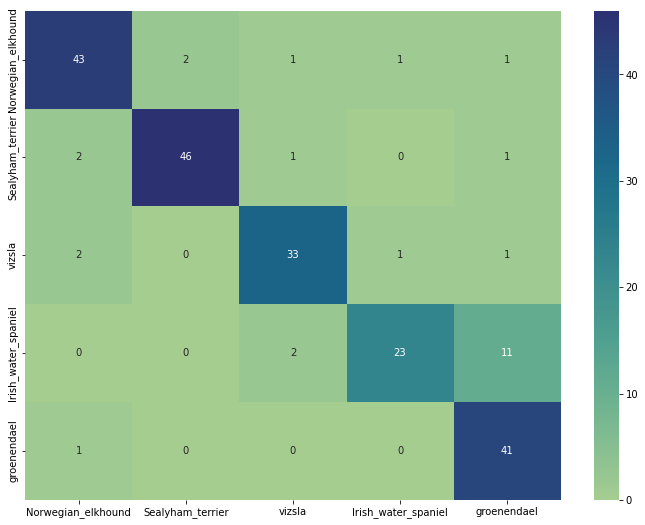

In [19]:

y_pred = model.predict(X_test,verbose=0)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors

y_true = np.argmax(Y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 9))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap="crest")
c.set(xticklabels=breed_list, yticklabels=breed_list)
print(" X-Achse = Predicted Labeles Y-Achse = die wahren Labels ")
